In [66]:
class Rect:
    def __init__(self, top, left, height, width):
        self.top = top
        self.left = left
        self.bottom = top + height
        self.right = left + width
        # self.height = height
        # self.width = width

    @property
    def height(self):
        return self.bottom - self.top
    
    @height.setter
    def height(self, value):
        self.bottom = value - self.top

    @property
    def width(self):
        return self.right - self.left
    
    @width.setter
    def width(self, value):
        self.right = value - self.left

    # @property
    # def bottom(self):
    #     return self.top + self.height
    
    # @bottom.setter
    # def bottom(self, value):
    #     self.height = self.height + (value - self.bottom)

    # @property
    # def right(self):
    #     return self.left + self.width

    # @right.setter
    # def right(self, value):
    #     self.width = self.width + (value - self.right)

    # def getValue(self, propertyShort: chr):
    #     match propertyShort:
    #         case 'T': return self.top
    #         case 'L': return self.left
    #         case 'B': return self.bottom
    #         case 'R': return self.right
    #         case 'H': return self.height
    #         case 'W': return self.width
    #         case _: Exception("Unknown property: " + propertyShort + ". Please use 'T', 'L', 'B', 'R', 'H', or 'W' instead.")
    
    def getValue(self, propertyShort: chr):
        if propertyShort=='T': return self.top
        elif propertyShort=='L': return self.left
        elif propertyShort=='B': return self.bottom
        elif propertyShort=='R': return self.right
        elif propertyShort=='H': return self.height
        elif propertyShort=='W': return self.width
        else: Exception("Unknown property: " + propertyShort + ". Please use 'T', 'L', 'B', 'R', 'H', or 'W' instead.")

    def setValue(self, propertyShort: chr, value: float):
        if propertyShort=='T': self.top = value
        elif propertyShort=='L': self.left = value
        elif propertyShort=='B': self.bottom = value
        elif propertyShort=='R': self.right = value
        elif propertyShort=='H': self.height = value
        elif propertyShort=='W': self.width = value
        else: Exception("Unknown property: " + propertyShort + ". Please use 'T', 'L', 'B', 'R', 'H', or 'W' instead.")

    def __str__(self):
        return "TLBR=(" + str(self.top) + ", " + str(self.left) + ", " + str(self.bottom) + ", " + str(self.right) + ")" \
         + "    TLHW=(" + str(self.top) + ", " + str(self.left) + ", " + str(self.height) + ", " + str(self.width) + ")"

    def __repr__(self):
        return self.__str__()


In [67]:
r = Rect(1, 2, 3, 4)
print(r)
r.bottom = 5
print(r)
r.setValue('R', 10)
print(r)
r.left = 3
print(r)
r.right = 6
print(r)

TLBR=(1, 2, 4, 6)    TLHW=(1, 2, 3, 4)
TLBR=(1, 2, 5, 6)    TLHW=(1, 2, 4, 4)
TLBR=(1, 2, 5, 10)    TLHW=(1, 2, 4, 8)
TLBR=(1, 3, 5, 10)    TLHW=(1, 3, 4, 7)
TLBR=(1, 3, 5, 6)    TLHW=(1, 3, 4, 3)


In [48]:
def getDBAlbumXMLConfig(mcfxFile):
    import sqlite3

    con = sqlite3.connect(mcfxFile)
    cur = con.cursor()
    res = cur.execute("SELECT Data FROM Files WHERE Filename='data.mcf'")

    xmlData = res.fetchone()

    print('Successfully read XML data from', mcfxFile)
    cur.close()
    con.close()  
    
    # with open('data.mcf.xml', "wb") as f:
    #     f.write(xmlData[0])

    if isinstance(xmlData[0], str):
        xmlString = xmlData[0]
    else:
        xmlString = xmlData[0].decode('UTF8')

    xmlString = xmlString[:xmlString.find('</fotobook>')+11]

    return xmlString

In [49]:
def getPagesWithImages(tree):
    parentMap = {c: p for p in tree.iter() for c in p}

    images = {}
    imageToPositionElement = {}

    for areaElement in tree.iter('area'):
        if areaElement.get('areatype') == 'imagearea':
            parentElement = parentMap[areaElement]
            pageNumber = int(parentElement.get('pagenr'))

            # Example: <position height="3160" left="-100" rotation="0" top="-100" width="6309.18" zposition="100"/>
            positionElement = areaElement.find('position')
            h = float(positionElement.get('height'))
            w = float(positionElement.get('width'))
            l = float(positionElement.get('left'))
            t = float(positionElement.get('top'))
            rect = Rect(t, l, h, w)

            if not pageNumber in images:
                images[pageNumber] = []

            images[pageNumber].append(rect)
            imageToPositionElement[rect] = positionElement

    return (images, imageToPositionElement)

In [68]:
def interfereHorizontally(i1, i2):
    if (i1.left >= i2.left and i1.left <= i2.right) or (i1.right >= i2.left and i1.right <= i2.right) or (i1.left <= i2.left and i1.right >= i2.right):
        return True
    return False

def interfereVertically(i1, i2):
    if (i1.top >= i2.top and i1.top <= i2.bottom) or (i1.bottom >= i2.top and i1.bottom <= i2.bottom) or (i1.top <= i2.top and i1.bottom >= i2.bottom):
        return True
    return False

# def getResultingConstraints(i1, i2, margin):
#     resultingConstraints = []

#     if i1.right <= i2.left:
#         if interfereVertically(i1, i2):
#             mid = i1.right + (i2.left - i1.right) / 2
#             # resultingConstraints.append((i1, 'W', i1.width + (mid - margin/2 - i1.right) ))
#             resultingConstraints.append((i1, 'R', mid - margin/2))
#             resultingConstraints.append((i2, 'L', mid + margin/2))
#     elif i1.left >= i2.right:
#         if interfereVertically(i1, i2):
#             mid = i2.right + (i1.left - i2.right) / 2
#             resultingConstraints.append((i1, 'L', mid + margin/2))
#             # resultingConstraints.append((i2, 'W', i2.width + (mid - margin/2 - i2.right) ))
#             resultingConstraints.append((i2, 'R', mid - margin/2))

#     if i1.bottom <= i2.top:
#         if interfereHorizontally(i1, i2):
#             mid = i1.bottom + (i2.top - i1.bottom) / 2
#             # resultingConstraints.append((i1, 'H', i1.height + (mid - margin/2 - i1.bottom) ))
#             resultingConstraints.append((i1, 'B', mid - margin/2))
#             resultingConstraints.append((i2, 'T', mid + margin/2))
#     elif i1.top >= i2.bottom:
#         if interfereHorizontally(i1, i2):
#             mid = i2.bottom + (i1.top - i2.bottom) / 2
#             resultingConstraints.append((i1, 'T', mid + margin/2))
#             resultingConstraints.append((i2, 'B', mid - margin/2))
#             # resultingConstraints.append((i2, 'H', i2.height + (mid - margin/2 - i2.bottom) ))

#     return resultingConstraints


def updateConstraints(constraints, i1, i2, margin):

    if i1.right <= i2.left:
        if interfereVertically(i1, i2):
            mid = i1.right + (i2.left - i1.right) / 2
            if mid - margin/2 < constraints[i1].right:
                constraints[i1].right = mid - margin/2
            if mid + margin/2 > constraints[i2].left:
                constraints[i2].left = mid + margin/2

    elif i1.left >= i2.right:
        if interfereVertically(i1, i2):
            mid = i2.right + (i1.left - i2.right) / 2
            if mid + margin/2 > constraints[i1].left:
                constraints[i1].left = mid + margin/2
            if mid - margin/2 < constraints[i2].right:
                constraints[i2].right = mid - margin/2

    if i1.bottom <= i2.top:
        if interfereHorizontally(i1, i2):
            mid = i1.bottom + (i2.top - i1.bottom) / 2
            if mid - margin/2 < constraints[i1].bottom:
                constraints[i1].bottom = mid - margin/2
            if mid + margin/2 > constraints[i2].top:
                constraints[i2].top = mid + margin/2

    elif i1.top >= i2.bottom:
        if interfereHorizontally(i1, i2):
            mid = i2.bottom + (i1.top - i2.bottom) / 2
            if mid + margin/2 > constraints[i1].top:
                constraints[i1].top = mid + margin/2
            if mid - margin/2 < constraints[i2].bottom:
                constraints[i2].bottom = mid - margin/2


In [79]:
def getNewCoordinates(pages, imageToPositionElement, pageHeight, pageWidth, newMargin):
    import itertools

    newCoordinates = {}

    for pageNumber in pages:
        images = pages[pageNumber]

# NEW !!!!!!!!!!!!
        constraints = {i: Rect(newMargin, newMargin, pageHeight - 2*newMargin, pageWidth - 2*newMargin) for i in images}
        for imagePair in itertools.combinations(images, 2):
            updateConstraints(constraints, imagePair[0], imagePair[1], newMargin)
        
        newCoordinates[pageNumber] = {imageToPositionElement[i]:r for i, r in constraints.items()}

# NEW !!!!!!!!!!!!


        # allConstraints = []
        # for i in images:
        #     borderConstraints = [(i, 'T', newMargin), (i, 'L', newMargin), (i, 'B', pageHeight - newMargin), (i, 'R', pageWidth - newMargin)]
        #     allConstraints.extend(borderConstraints)
        
        # allConstraints = sorted(allConstraints, key=lambda c: (c[0].top, c[0].left, c[0].bottom, c[0].right ) )

        # if pageNumber == 12:
        #     print()
    
        # for imagePair in itertools.combinations(images, 2):
        #     resultingConstraints = getResultingConstraints(imagePair[0], imagePair[1], newMargin)
        #     allConstraints = allConstraints + resultingConstraints

        # newCoordinates[pageNumber] = {imageToPositionElement[i] : Rect(i.top, i.left, i.height, i.width) for i in images}
        

        # for key, g in itertools.groupby(allConstraints, lambda c: (c[0].top, c[0].left, c[0].bottom, c[0].right, c[1]) ):
        #     group = list(g)
        #     lb = min(group, key=lambda c: c[2])
        #     ub = max(group, key=lambda c: c[2])
        #     print(key, lb, ub)

        # for c in allConstraints:
        #     image = c[0]
        #     positionElement = imageToPositionElement[image]

        #     if not positionElement is None: # None for border rectangles
        #         oldVal = newCoordinates[pageNumber][positionElement].getValue(c[1])

        #         if ((c[1]=='T' or c[1]=='L') and c[2] > oldVal) or ((c[1]=='B' or c[1]=='R') and c[2] < oldVal):
        #             newCoordinates[pageNumber][positionElement].setValue(c[1], c[2])
    
    return newCoordinates

In [80]:
def adjustCoordinates(tree, newCoordinates):
    for pageNumber in newCoordinates:
        for (posEl, rect) in newCoordinates[pageNumber].items():
            if not posEl is None:
                posEl.set('top', str(rect.top))
                posEl.set('left', str(rect.left))
                posEl.set('height', str(rect.height))
                posEl.set('width', str(rect.width))
            
    return None

In [93]:
import xml.etree.ElementTree as et

xmlString = getDBAlbumXMLConfig('test.mcfx')
root = et.fromstring(xmlString)

(pages, imageToPositionElement) = getPagesWithImages(root)

pageHeight = 2900 #2960
pageWidth = 5800 #6010
newMargin = 100

newCoordinates = getNewCoordinates(pages, imageToPositionElement, pageHeight, pageWidth, newMargin)

adjustCoordinates(root, newCoordinates)
newXML = et.tostring(root)

et.ElementTree(root).write(open('data.mcf.new.xml', 'wb'), encoding='UTF-8', xml_declaration=True)

Successfully read XML data from test.mcfx


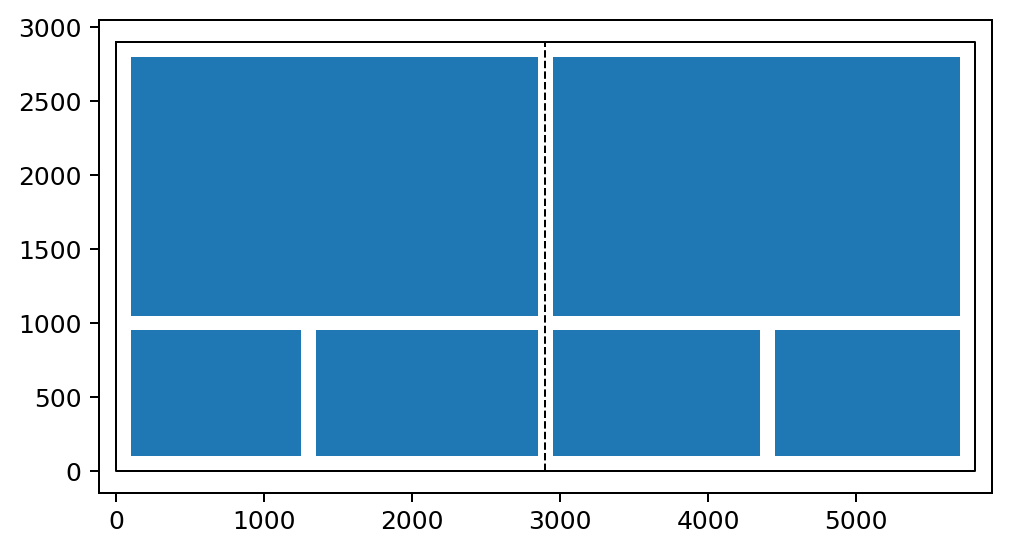

In [94]:
(pages, imageToPositionElement) = getPagesWithImages(root)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['figure.dpi'] = 180

fig, ax = plt.subplots()
ax.plot([0, 0, pageWidth, pageWidth, 0],[pageHeight, 0, 0, pageHeight, pageHeight], 'k', linewidth=0.8)
ax.plot([pageWidth/2, pageWidth/2],[0, pageHeight], 'k--', linewidth=0.8)

for i in pages[12]:
    ax.add_patch(Rectangle((i.left, i.top), i.width, i.height))

ax.set_aspect('equal', 'box')
plt.xlim(-pageWidth*0.02 , pageWidth*1.02 )
plt.show(-pageHeight*0.02, pageHeight*1.02)